# Calculating Radius of Gyration for Proteins

We open some `.pdb` files containing protein structures, get the coordinates of individual atoms and calculate the radii of gyration for the structures.

In [1]:
import numpy as np
import pandas as pd
import os #for getting the working directory
from Bio.PDB import * #only used for downloading PDB files
import matplotlib.pyplot as plt
from read_process_PDB import *
import seaborn as sns; sns.set(); sns.set_context('talk')
#for interactive visualization

In [2]:
directory = os.getcwd() #get working directory, this will help us name our stored .pdb files in a shorter fashion

## Downloading Files

Let's download some `.pdb` files of interest. We want files for proteins with the following structure IDs:

1. 1EMA
2. 5HMP
3. 4B50
4. 5JVM
5. 1BOM
6. 6FQF
7. 1OED

The `.pdb` files will be stored in the current directory. Once the files are downloaded we open them and store the protein IDs and the pointers for their `.pdb` files in a dataframe `prot`. For instance, `prot['pointer'][i]` gives us the dataframe containing the atomic information for the ith protein.

In [3]:
prot = pd.DataFrame(['1EMA','5HMP','4B50','5JVM','1BOM','6FQF','1OED'],columns = ['ID']) #construct dataframe
prot['file_name'] = [PDBList().retrieve_pdb_file(p,file_format='pdb').replace(directory,'.') for p in prot['ID']]

prot['pointer'] = [open(name) for name in prot['file_name']]
#this will store the file pointers within a column of the dataframe

Structure exists: '/Users/shivamchitnis/Documents/GitHub/rad-gyres/em/pdb1ema.ent' 
Structure exists: '/Users/shivamchitnis/Documents/GitHub/rad-gyres/hm/pdb5hmp.ent' 
Structure exists: '/Users/shivamchitnis/Documents/GitHub/rad-gyres/b5/pdb4b50.ent' 
Structure exists: '/Users/shivamchitnis/Documents/GitHub/rad-gyres/jv/pdb5jvm.ent' 
Structure exists: '/Users/shivamchitnis/Documents/GitHub/rad-gyres/bo/pdb1bom.ent' 
Structure exists: '/Users/shivamchitnis/Documents/GitHub/rad-gyres/fq/pdb6fqf.ent' 
Structure exists: '/Users/shivamchitnis/Documents/GitHub/rad-gyres/oe/pdb1oed.ent' 


## Parsing and Visualizing

Let's open one of these `.pdb` files and parse through them to obtain atomic coordinates so that we can visualize the structure. The structure of the `.pdb` file seems to lend itself very nicely to `pandas` dataframes. Therefore, we will parse the data into dataframes which can then be sliced according to convenience. The functions to parse and plot atomic information of the proteins are contained in `read_process_PDB.py`. We use `plotly` to generate the interactive plots. 

`note: some features might not render in Safari`

### 1EMA
Let's visualize one of the proteins. It would be nice to look at the position $\text{C}_\alpha$, $\text{C}$ and $\text{N}$ atoms that make up the skeleton of the peptide chain. We can look at 1EMA which seems to be a GFP protein.

In [4]:
ID = 0
plot_protein(atomize(prot['pointer'][ID]),title = prot['ID'][ID])

Notice the barrel like structure of the protein. The N-terminus is shown in red and the C-terminus is shown in blue. This protein has a single subunit.

### 5JVM
Let's visualize 5JVM which seems to be a histone dimer.

In [5]:
ID = 3
plot_protein(atomize(prot['pointer'][ID]),title = prot['ID'][ID])

The skeleton clearly shows us the interaction between the two peptide chains. The histone 'handshake' is unmistakable.

### 5HMP

In [6]:
ID = 1
plot_protein(atomize(prot['pointer'][ID]),title = prot['ID'][ID])

This protein is massive compared to the previous ones. It is some kind of myosin protein and you can see how the two subunits interact in a small spatial region.

## Centre of Mass

Since we have the positions of all atoms in the protein, we should be able to calculate the centre of mass for the protein using the following relation:

$\vec{r}_{COM} = \dfrac{\sum_i^N \vec{r}_iM_i}{\sum_i M_i}$

In [7]:
def com(structure):
    com = np.zeros(3)
    mass = structure['element'].replace({'N':14,'C':12,'H':1,'O':16,
                                                               'S':32,'O1-':16}).astype('float')
    M = np.sum(np.array(mass))
    com = mass.dot(structure[['x','y','z']])
    return np.array(com/M)

### 6FQF

In [8]:
ID = 5
COM = com(atomize(prot['pointer'][ID]))
plot_protein(atomize(prot['pointer'][ID]),title = prot['ID'][ID],point=COM)

Notice how the centre of mass of the haemoglobin protein (in black) sits at the centre of the 4 subunits of the haemoglobin molecule.

### 1OED

In [9]:
ID = 6
COM = com(atomize(prot['pointer'][ID]))
plot_protein(atomize(prot['pointer'][ID]),title = prot['ID'][ID],point=COM)

This protein is membrane pore that allows acetylcholine to pass through. Note how the centre of mass sits right in the middle of the pore.

# Radius of Gyration

Finally, we should be able to calculate the radius of gyration for the protein using the following relationship:

$\big<R_G^2\big> = \dfrac{1}{N} \sum_i^N (\vec{r}_i - \vec{r}_{COM})^2$

In [10]:
def radius_of_gyration(structure,com):
    N = np.size(np.array(structure['x']))
    Rg2 = np.array(structure[['x','y','z']]-com)
    Rg = np.sqrt((Rg2*Rg2).sum(-1).sum()/N)
    return Rg

### 4B50

In [11]:
ID = 2
r_g = radius_of_gyration(atomize(prot['pointer'][ID]),com(atomize(prot['pointer'][ID])))
plot_protein(atomize(prot['pointer'][ID]),title = prot['ID'][ID],
             point=com(atomize(prot['pointer'][ID])),sphere=r_g)

Here, instead of plotting the skeleton we have plotted the location of all the atoms. We can see that this protein is relatively spherical in shape. Therefore the radius of gyration is a good estimate of its size in angstroms.

### 1BOM

In [12]:
ID = 4
r_g = radius_of_gyration(atomize(prot['pointer'][ID]),com(atomize(prot['pointer'][ID])))
plot_protein(atomize(prot['pointer'][ID]),title = prot['ID'][ID],
             point=com(atomize(prot['pointer'][ID])),sphere=r_g)

This insulin like peptide from insects is not spherically symmetric since it has two long chains that lie at an angle to each other. For proteins like this we can see that the radius of gyration is a bad estimate of size.

## Radius of Gyration vs. Chain Length

We can calculate the radius of gyration for the proteins we obtained as a function of the chain length for each of the proteins we have in our set. As a proxy for the chain length, we will calculate the number of $C_\alpha$ atoms in the protein.

In [13]:
prot['chain_length'] = [len(atomize(p).query('name == "CA"')) for p in prot['pointer']]
prot['Rg'] = [radius_of_gyration(atomize(p),com(atomize(p))) for p in prot['pointer']]

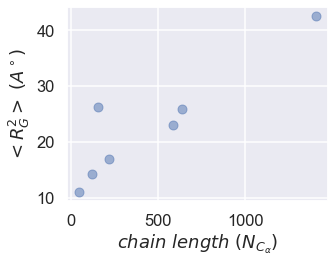

In [14]:
plt.figure(figsize=(5,4))
plt.plot(prot['chain_length'],prot['Rg'],'o',alpha=0.5)
plt.xlabel(r'$chain\ length\ (N_{C_\alpha})$')
plt.ylabel(r'$<R_G^2>\ (A^\circ)$')
plt.tight_layout()
plt.show()

We can see that $\big<R_g^2\big>$ scales linearly as a function of the number of $C_\alpha$ atoms. It is interesting to note that 5VJM which as we saw above is a molecule that is much wider in one dimension than in the other has a higher than expected $\big<R_g^2\big>$.


### Subunits
To confirm that this trend holds for individual subunits we can calculate radii of gyration for individual subunits of all the proteins in our set and plot them as a function of the number of carbon atoms in them. 

In [15]:
R_g = []
sub_len = []
for p in prot['pointer']:
    structure = atomize(p)
    _,subunits = structure['chain'].factorize()
    for s in subunits:
        sub = structure.loc[structure['chain'] == s]
        R_g.append(radius_of_gyration(sub,com(sub)))
        sub_len.append(len(sub.query('name == "CA"')))
R_g = np.array(R_g)
sub_len = np.array(sub_len)

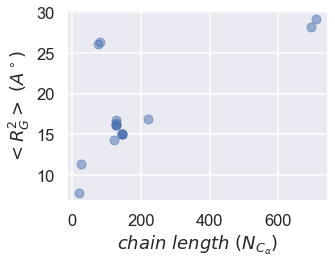

In [16]:
plt.figure(figsize=(5,4))
plt.plot(sub_len,R_g,'o',alpha=0.5)
plt.xlabel(r'$chain\ length\ (N_{C_\alpha})$')
plt.ylabel(r'$<R_G^2>\ (A^\circ)$')
plt.tight_layout()
plt.show()

Again, we see that the trend holds except for the two subunits of 5VJM which are longer in one dimension.

## Takeaways
It is interesting to see how proteins are not blobs but have highly regular structures like helices and loops. The scaling of $\big<R_G^2\big> with chain length confirms that proteins behave like random-walk polymers to an extent.